Importing necessary Libraries and the data

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

# Set seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Load the data
df = pd.read_csv("online_gaming_behavior_dataset.csv")

Data Cleaning and Preprocessing

In [6]:
# Check for missing values
print(df.isnull().sum())
# Fill missing values
# Age: Fill with median to avoid outlier skew
# AvgSessionDurationMinutes: Fill with mean to retain overall distribution
df['Age'].fillna(df['Age'].median(), inplace=True)
df['AvgSessionDurationMinutes'].fillna(df['AvgSessionDurationMinutes'].mean(), inplace=True)

# Handle outliers using Z-score for numeric columns
num_cols = ['PlayTimeHours', 'PlayerLevel', 'AchievementsUnlocked']
df = df[(np.abs(zscore(df[num_cols])) < 3).all(axis=1)]

# Encode categorical variables
categorical_cols = ['Gender', 'Location', 'GameGenre', 'GameDifficulty']
df = pd.get_dummies(df, columns=categorical_cols)

# Encode target variable
engagement_map = {'Low': 0, 'Medium': 1, 'High': 2}
df['EngagementLevel'] = df['EngagementLevel'].map(engagement_map)

# Normalize selected features
scaler = MinMaxScaler()
scaled_features = ['PlayTimeHours', 'SessionsPerWeek', 'AvgSessionDurationMinutes', 'AchievementsUnlocked']
df[scaled_features] = scaler.fit_transform(df[scaled_features])


PlayerID                     0
Age                          0
Gender                       0
Location                     0
GameGenre                    0
PlayTimeHours                0
InGamePurchases              0
GameDifficulty               0
SessionsPerWeek              0
AvgSessionDurationMinutes    0
PlayerLevel                  0
AchievementsUnlocked         0
EngagementLevel              0
dtype: int64


/var/folders/dx/k6lhd0mn4cd90llghxh4gd_w0000gn/T/ipykernel_9524/3438938547.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
/var/folders/dx/k6lhd0mn4cd90llghxh4gd_w0000gn/T/ipykernel_9524/3438938547.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

Feature Engineering and Runninng the Model


Top correlated features:
 EngagementLevel              1.000000
TotalPlayMinutesPerWeek      0.767667
SessionsPerWeek              0.605996
AvgSessionDurationMinutes    0.476698
AchievementsUnlocked         0.060576
PlayerLevel                  0.059315
InGamePurchases              0.008209
GameGenre_Strategy           0.007700
Location_Asia                0.006110
Gender_Female                0.004978
Name: EngagementLevel, dtype: float64

Cross-Validation Scores:
Logistic Regression: 0.8867
Random Forest: 0.8978
XGBoost: 0.8978


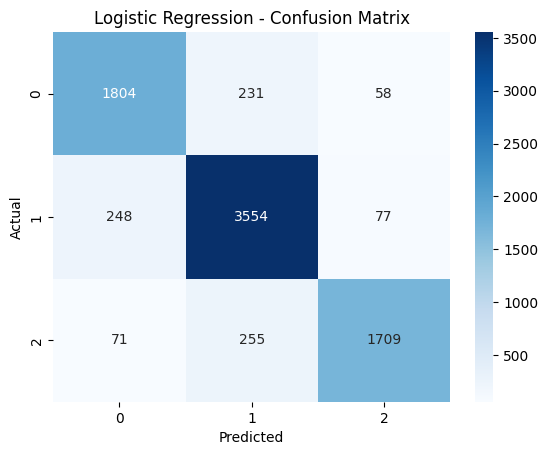

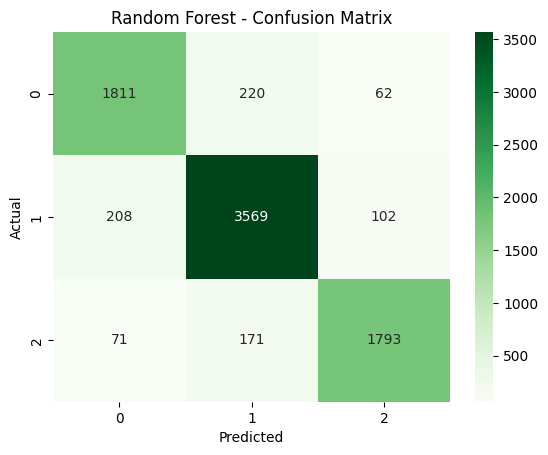

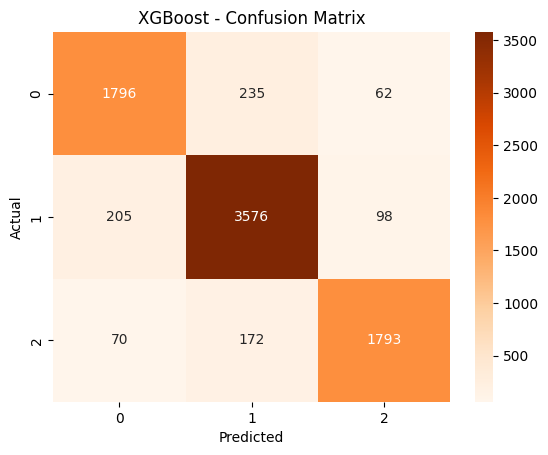


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      2093
           1       0.88      0.92      0.90      3879
           2       0.93      0.84      0.88      2035

    accuracy                           0.88      8007
   macro avg       0.89      0.87      0.88      8007
weighted avg       0.88      0.88      0.88      8007


Random Forest Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2093
           1       0.90      0.92      0.91      3879
           2       0.92      0.88      0.90      2035

    accuracy                           0.90      8007
   macro avg       0.89      0.89      0.89      8007
weighted avg       0.90      0.90      0.90      8007


XGBoost Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      2093
           1       0.90      0.92      0.91      3879
      

In [7]:
# Feature Engineering
# Create new feature: Total playtime per week
df['TotalPlayMinutesPerWeek'] = df['SessionsPerWeek'] * df['AvgSessionDurationMinutes']

# Feature Selection using correlation
target_corr = df.corr()['EngagementLevel'].sort_values(ascending=False)
print("\nTop correlated features:\n", target_corr.head(10))

# Select top features manually or based on importance (can use RF importance later)
selected_features = ['TotalPlayMinutesPerWeek', 'PlayerLevel', 'AchievementsUnlocked', 'PlayTimeHours', 'InGamePurchases']

X = df[selected_features]
y = df['EngagementLevel']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Baseline Model Implementation
# Logistic Regression
log_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

# Random Forest with GridSearchCV
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE),
                       param_grid=rf_param_grid,
                       cv=5,
                       scoring='accuracy',
                       n_jobs=-1)
rf_grid.fit(X_train, y_train)
best_rf_model = rf_grid.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

# XGBoost with GridSearchCV
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_grid = GridSearchCV(XGBClassifier(eval_metric='mlogloss', random_state=RANDOM_STATE),
                        param_grid=xgb_param_grid,
                        cv=5,
                        scoring='accuracy',
                        n_jobs=-1)
xgb_grid.fit(X_train, y_train)
best_xgb_model = xgb_grid.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)

# Cross-validation
log_cv_scores = cross_val_score(log_model, X, y, cv=5)
rf_cv_scores = cross_val_score(best_rf_model, X, y, cv=5)
xgb_cv_scores = cross_val_score(best_xgb_model, X, y, cv=5)

print("\nCross-Validation Scores:")
print(f"Logistic Regression: {log_cv_scores.mean():.4f}")
print(f"Random Forest: {rf_cv_scores.mean():.4f}")
print(f"XGBoost: {xgb_cv_scores.mean():.4f}")

# Confusion Matrices
cm_log = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges')
plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Reports
print("\nLogistic Regression Report:")
print(classification_report(y_test, y_pred_log))

print("\nRandom Forest Report:")
print(classification_report(y_test, y_pred_rf))

print("\nXGBoost Report:")
print(classification_report(y_test, y_pred_xgb))

# Summary Table
model_scores = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_log, average='macro'),
        f1_score(y_test, y_pred_rf, average='macro'),
        f1_score(y_test, y_pred_xgb, average='macro')
    ]
})
print("\nModel Scores:")
print(model_scores)

Data Visualizations

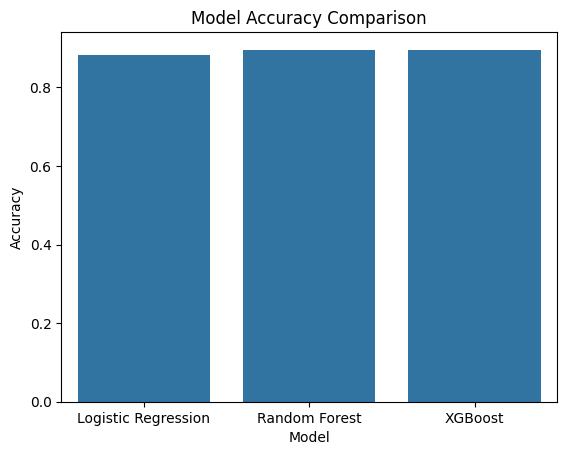

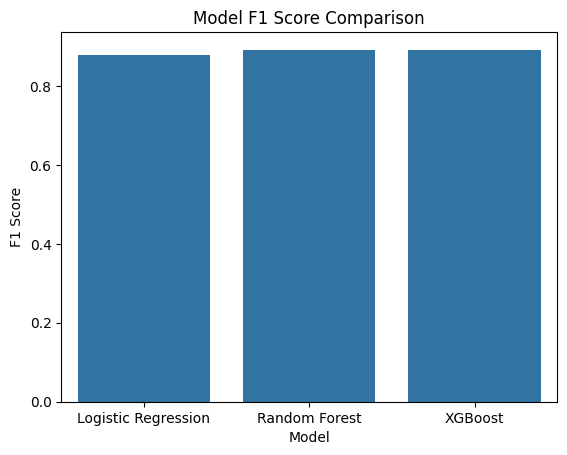

/var/folders/dx/k6lhd0mn4cd90llghxh4gd_w0000gn/T/ipykernel_9524/4054333124.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


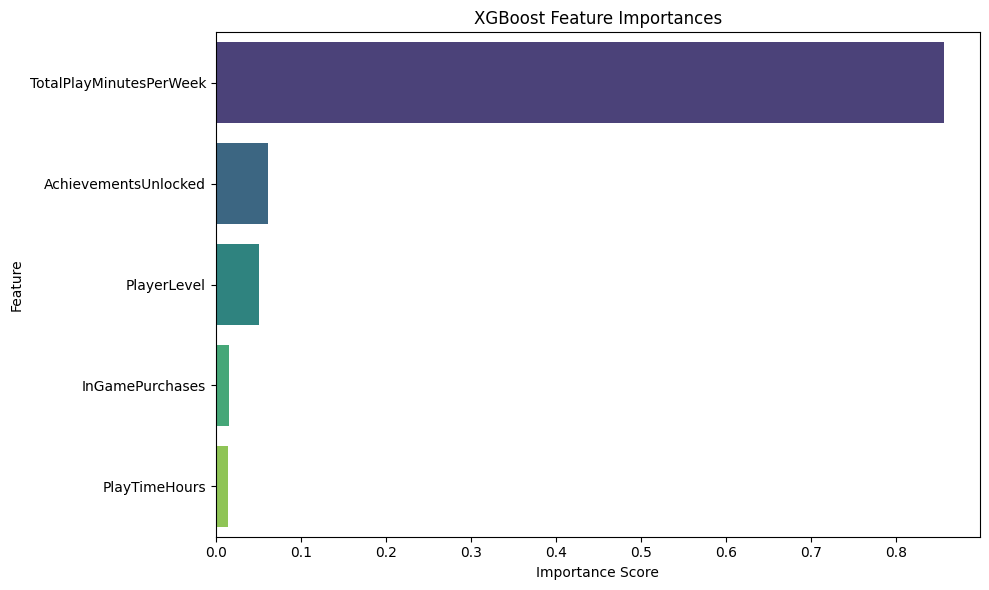

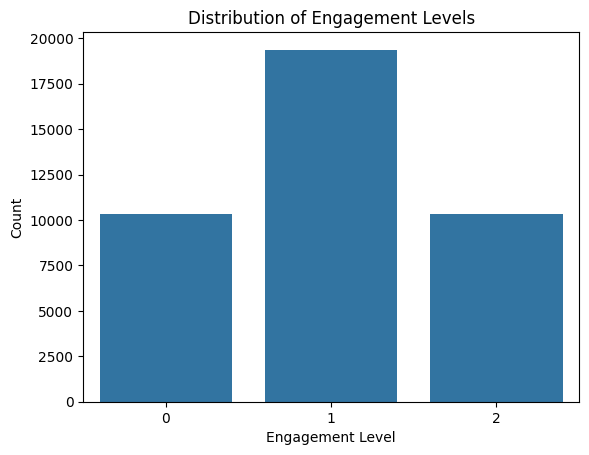

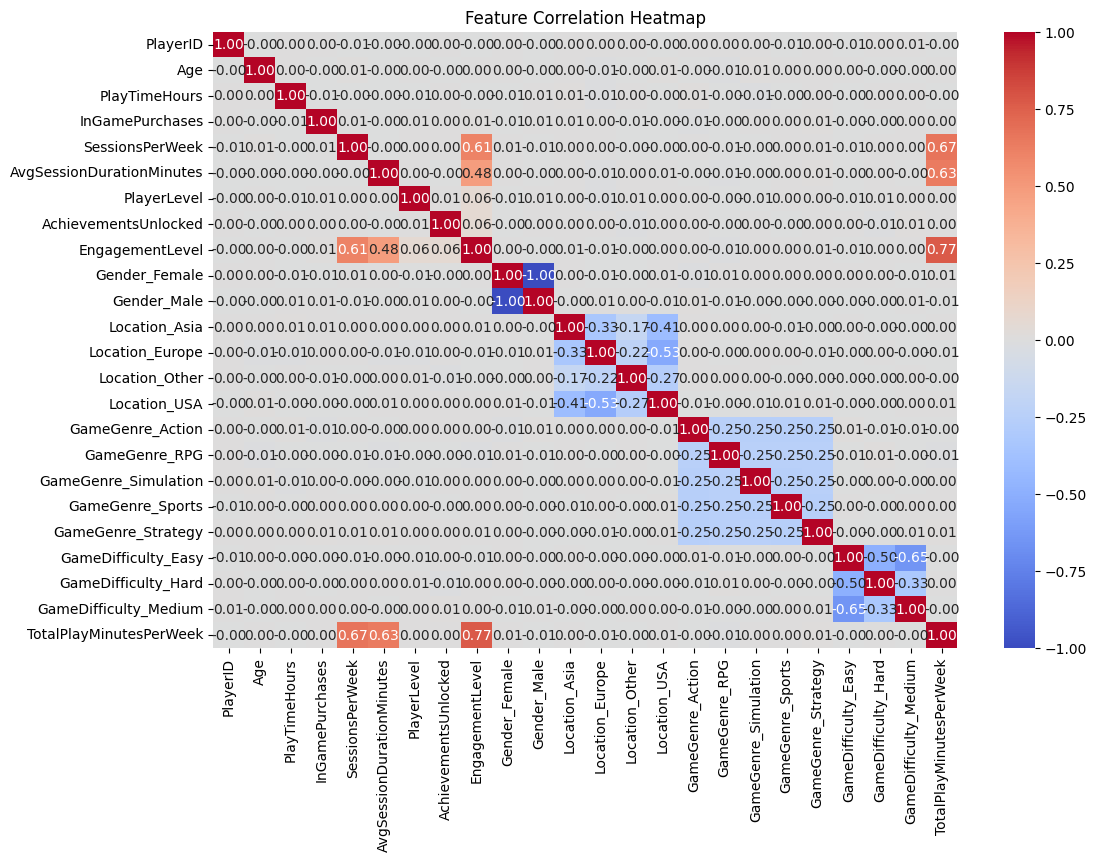

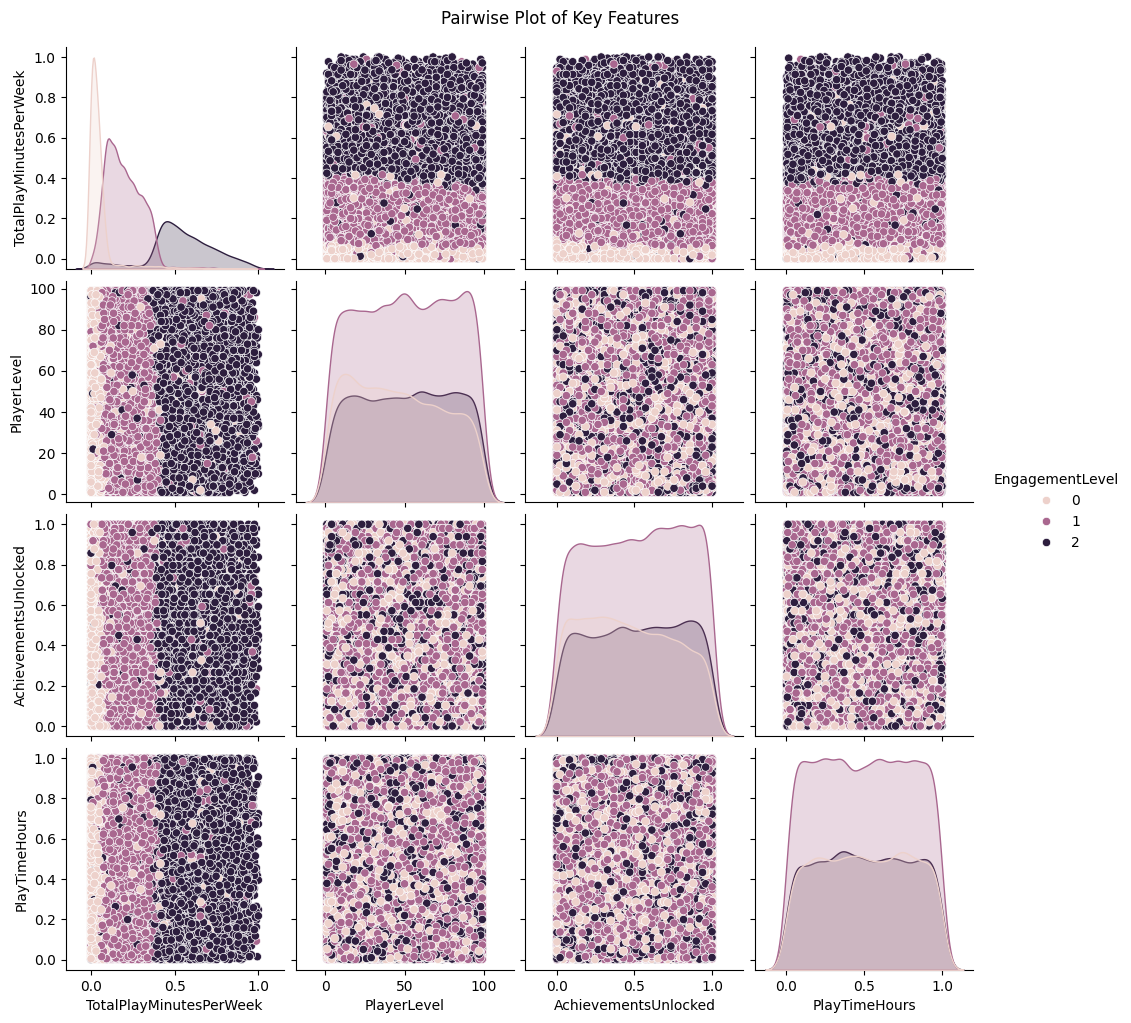

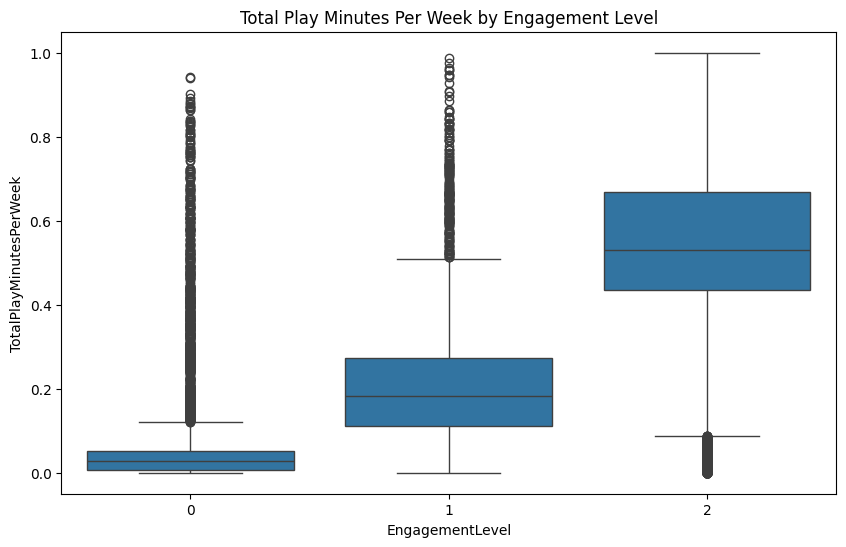

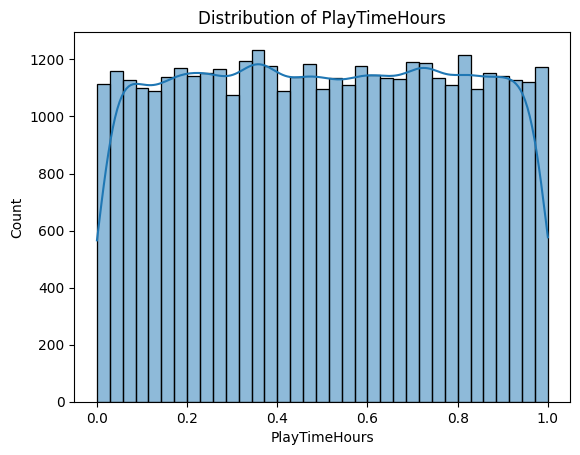

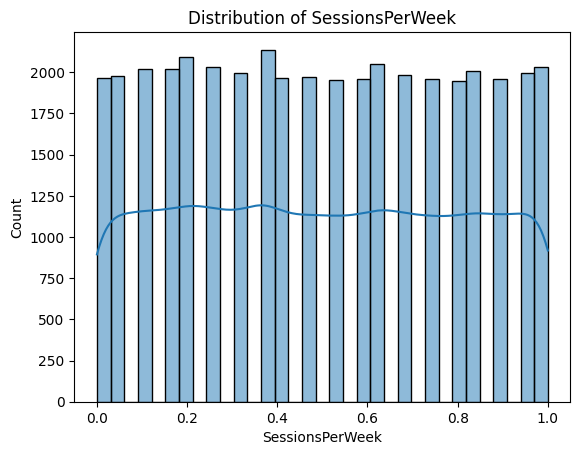

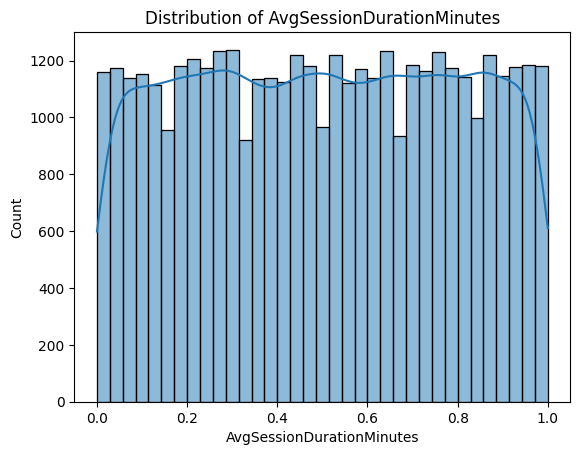

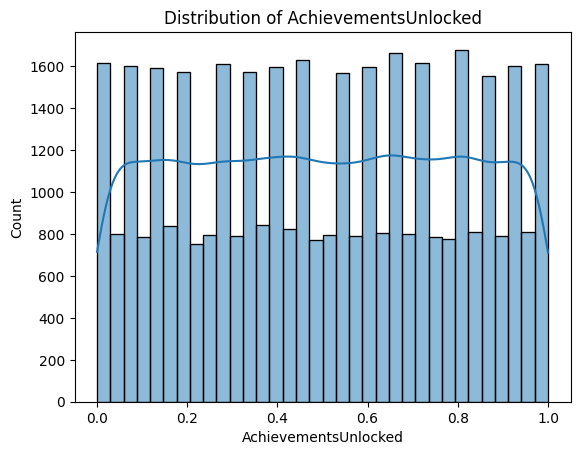

In [8]:
# Visual Comparison
sns.barplot(x='Model', y='Accuracy', data=model_scores)
plt.title("Model Accuracy Comparison")
plt.show()

sns.barplot(x='Model', y='F1 Score', data=model_scores)
plt.title("Model F1 Score Comparison")
plt.show()

#Feature Importance (XGBoost)
importances = best_xgb_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('XGBoost Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

#Target Variable Distribution
sns.countplot(x='EngagementLevel', data=df)
plt.title("Distribution of Engagement Levels")
plt.xlabel("Engagement Level")
plt.ylabel("Count")
plt.show()

#Correlation Heatmap (numeric features)
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

#Pairplot of Key Features
selected_numeric = ['TotalPlayMinutesPerWeek', 'PlayerLevel', 'AchievementsUnlocked', 'PlayTimeHours', 'EngagementLevel']
sns.pairplot(df[selected_numeric], hue='EngagementLevel', diag_kind='kde')
plt.suptitle("Pairwise Plot of Key Features", y=1.02)
plt.show()

#Boxplot: Feature Distributions by Engagement
plt.figure(figsize=(10, 6))
sns.boxplot(x='EngagementLevel', y='TotalPlayMinutesPerWeek', data=df)
plt.title("Total Play Minutes Per Week by Engagement Level")
plt.show()

#Distribution Plot of Normalized Features
for feature in scaled_features:
    sns.histplot(df[feature], kde=True)
    plt.title(f"Distribution of {feature}")
    plt.show()